# Pixel-level

By Cascade Tuholske, Sep 2020 <br>
Notebook to generate pixel agreement, coeffiecent of variation of popgrid data, and distributions of pixels. <br>

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio 
import xarray as xr
import geopandas as gpd
import glob
import rioxarray as rio
from scipy.stats import variation 
import rasterio.mask
import matplotlib.pyplot as plt

## Pixel Aggreement

In [16]:
#### File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'
country = '_ECU.tif'

In [17]:
# 2021.01.20 - keeping GPWv4
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*all'+country)
for rst in rst_fns: print(rst) # check them

/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_ECU.tif
/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_ECU.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_ECU.tif
/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_ECU.tif
/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_ECU.tif


In [18]:
# Get all arrays
arrs = []

for rst in rst_fns:
    arr = rasterio.open(rst).read(1)
    arrs.append(arr)

In [19]:
# find areas of agreement
zeros = []
for arr in arrs:
    zero = arr > -999
    zero = zero.astype(int)
    zeros.append(zero)

agg = sum(zeros)

In [20]:
agg32 = agg.astype('int32')

In [21]:
# get meta data & write raster 
out_meta = rasterio.open(rst_fns[0]).meta
out_meta['dtype'] = 'int32'

In [22]:
fn_out = DATA_PATH+'interim/agg'+country
with rasterio.open(fn_out, "w", **out_meta) as dest:
    dest.write(agg32, 1)

## Range across rasters

In [23]:
def open_rst(rst_fn):
    "function opens a raster and makes it into a xarray object"
    
    rst = xr.DataArray(rasterio.open(rst_fn).read(1), dims = ['y', 'x']) # y and x are our 2-d labels
    
    return rst

In [24]:
def rst_range(rst_fns, fn_out, save = False):
    """ Calc pixel-level range on stacked arrays and writes it out as a raster, returns the range, max and min arrs
    fst_fns = list of rasters 
    fn_out = file name and path to write out coef var raster
    save = if save == true, will write raster, default = False
    
    """
    
    arr_list = [] # empty list
    
    # open and stack arrays
    for rst_fn in rst_fns:
        
      
        rst_arr = rasterio.open(rst_fn).read(1)
        arr_list.append(rst_arr)
    
    arr3d = np.dstack([arr_list])
        
    # mask zeros
    arr3d[arr3d == -999] = 0 # Set NAN to zeros
        
    # Get range
    arr_min = np.amin(arr3d, axis = 0)
    arr_max = np.amax(arr3d, axis = 0)
    arr_range = arr_max - arr_min
    arr_out = arr_range.data
    
    # get meta data & write raster 
    out_meta = rasterio.open(rst_fns[0]).meta
    out_meta.update({'dtype' : 'float64'})
    
    if save == True: 
        with rasterio.open(fn_out, "w", **out_meta) as dest:
            dest.write(arr_out, 1)
        
    return arr_range, arr_max, arr_min

In [25]:
def make_plot(data_min, data_range, title, color, save = None, fn_out = None):
    
    """ plots min vs range for pop grid compare
    Args:
        data_min, = data min values as array
        data_range = data max values as array
        title = tile of plot as str
        color = color for points
        save = if True saves plot
        fn_out = name of fn to save
    """
    
    # Set up
    fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
    ws = 0.25
    fig.subplots_adjust(wspace=ws)
    scale = 10**3 

    # plot
    X = np.delete(data_min.flatten(), np.where(data_range.flatten() == 0)) # remove all zero ranges
    Y = np.delete(data_range.flatten(), np.where(data_range.flatten() == 0)) # remove all zero ranges
    axs.scatter(X/scale, Y/scale, alpha = 0.3, color = color, marker = 'o')#, edgecolors = 'darkslategray')

    # titles & lables & ticks
    axs.set_title(title, fontsize = 25)
    axs.set_xlabel('Pop Min', fontsize = 20)
    axs.set_ylabel('Pop Range', fontsize = 20)
    axs.tick_params(axis = 'both', which = 'major', labelsize = 20)
    axs.tick_params(axis = 'both', which = 'minor', labelsize = 20)

    if save == True:
        plt.savefig(fn_out, dpi = 300, bbox_inches='tight', facecolor = 'w')

/Users/cascade/Github/PopGridCompare/data/interim/WP16_rural_NPL.tif
/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_rural_NPL.tif
/Users/cascade/Github/PopGridCompare/data/interim/GHS15_rural_NPL.tif
/Users/cascade/Github/PopGridCompare/data/interim/LS15_rural_NPL.tif
/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_rural_NPL.tif


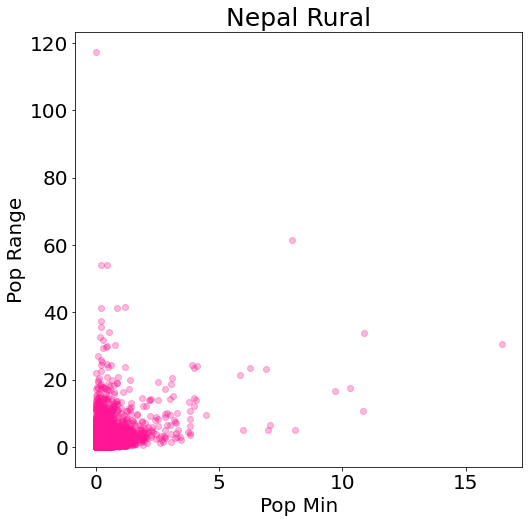

In [28]:
# File Paths & FNs --- Update by geography urban/rural for MMZ, ECU, NPL
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

# args
country = 'rural_NPL'
title = 'Nepal Rural'
fn_out = DATA_PATH+'FIGS/MS/Fig2_'+country+'.png'
color = 'deeppink'#'midnightblue'

# get rst names
rst_fns = glob.glob('/Users/cascade/Github/PopGridCompare/data/interim/*'+country+'.tif')
for rst in rst_fns: print(rst) # check them
    
# make data
data_range, data_max, data_min = rst_range(rst_fns, fn_out, save = False)

# plot & save
make_plot(data_min = data_min, data_range = data_range, title = title, color = color, save = True, fn_out = fn_out)

## What are the stats?

In [ ]:
# File Paths & FNs
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [ ]:
def get_stats(country, mask):
    
    """ gets count of rural/urban pixels, max and inhabitied pixels 
    Args: 
        country = country.tif
        mask = full path file name of bianary raster for the country's area 
    """
    
    # Stuff to fill
    df = pd.DataFrame()
    
    countries = []
    labels = []
    urban_counts = []
    urban_maxs = []
    urban_sums = []
    rural_counts = []
    rural_maxs = []
    rural_sums = []
    uninhabated = []
    pcts = []
    
    # urban labels, counts & max
    rst_fns = sorted(glob.glob(DATA_PATH+'interim/*urban_'+country))
    for rst in rst_fns:
        
        label = rst.split('interim/')[1].split('_urban')[0]
        labels.append(label)
        cmax = rasterio.open(rst).read(1).flatten().max()
        urban_maxs.append(cmax)
        urban = list(filter(lambda x: x > 0, rasterio.open(rst).read(1).flatten()))
        urban_count = len(urban)
        urban_sum = sum(urban)
        urban_counts.append(urban_count)
        urban_sums.append(urban_sum)
    
    # rural labels, counts & max
    rst_fns = sorted(glob.glob(DATA_PATH+'interim/*rural_'+country))
    for rst in rst_fns:
        
        cmax = rasterio.open(rst).read(1).flatten().max()
        rural_maxs.append(cmax)
        rural = list(filter(lambda x: x > 0, rasterio.open(rst).read(1).flatten()))
        rural_count = len(rural)
        rural_sum = sum(rural)
        rural_counts.append(rural_count)
        rural_sums.append(rural_sum)
    
    # Uninhabitated 
    rst_fns = sorted(glob.glob(DATA_PATH+'interim/*all_'+country))
    for rst in rst_fns:
        a = len(list(filter(lambda x: x != -999, rasterio.open(rst).read(1).flatten()))) # ! nan pixels
        b = len(list(filter(lambda x: x == 1, rasterio.open(mask).read(1).flatten()))) # all pixels w/in bounds
        c = b - a
        pct = c / b * 100 # pct uninhabated
        uninhabated.append(c)
        pcts.append(pct)

    # Population dataframe
    df['country'] = [country.split('.tif')[0]] * len(rst_fns)
    df['label'] = labels
    df['urban_max'] = urban_maxs
    df['rural_max'] = rural_maxs
    df['urban_sum'] = urban_sums
    df['rural_sum'] = rural_sums
    df['total_pop'] = df['urban_sum'] + df['rural_sum']
    df['urban_count'] = urban_counts
    df['rural_count'] = rural_counts
    df['uninhabated'] = uninhabated
    df['pct'] = pcts
    
    return df

In [ ]:
# Get stats Nepal
country = 'NPL.tif'
mask_fn = DATA_PATH+'interim/NPL-rst.tif'
df1 = get_stats(country, mask_fn)

In [ ]:
# Get stats Ecu
country = 'ECU.tif'
mask_fn = DATA_PATH+'interim/ECU-rst.tif'
df2 = get_stats(country, mask_fn)

In [ ]:
# Get stats MMZ
country = 'MMZ.tif'
mask_fn = DATA_PATH+'interim/MMZ-rst.tif'
df3 = get_stats(country, mask_fn)

In [ ]:
# Concat
dfs = [df1, df2, df3]
df_out = pd.concat(dfs)
df_out

In [ ]:
# Write it out
fn_out = DATA_PATH+'processed/Table1.csv'
df_out.to_csv(fn_out)